<a href="https://colab.research.google.com/github/yvesheri4/short-pulse-electron-beam-python/blob/main/Paper3_v0701_accelerated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper 3 - Space charge effects with time varying current injection

____

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import constants
import seaborn as sns
eps_0 = constants.epsilon_0
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML
# import scienceplots

# plt.style.use(['no-latex'])

size = 24
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':1.5,
   'figure.figsize': [6.5, 4.5]
   }
plt.rcParams.update(params)

### Particles

In [24]:
import numpy as np
from scipy import constants as cst

# Define the particle class
class Particle:
    def __init__(self, mass,charge, index):
        self.mass = mass
        self.i = index
        self.charge = charge
        self.r = np.zeros((1), dtype='float64')
        self.v = np.zeros((1), dtype='float64')

    def initPos(self, x):
        self.r = x

    def initSpeed(self, vx):
        self.v = vx

    def Heri_push(self, dt, E):
        temp = self.v
        self.v += 1.5*E*dt
        self.r += 3*(self.v+temp)*dt/2

### Functions

#### Particles related functions

In [25]:
def Create_Particle_list(mass,charge):
    List = []
    for i in range(len(charge)):
        List.append(Particle(mass[i],charge[i],i+1))
    return List

def Init_Particle_list(List,InitPos,InitSpeed):
    for i in range(len(List)):
        List[i].initPos(InitPos[i])
        List[i].initSpeed(InitSpeed[i])
    return List


#### Fields related functions

In [26]:
def Electric_Field(List,V0,d,t,Dt):

    N_inj = 1+int(t/Dt)
    if N_inj > len(List):
        N_inj = len(List)

    E = np.zeros(len(List))

    sum1 = 0
    List2 = []
    for j in range(N_inj):
        if List[j].r < 1 and List[j].r >=0:
            sum1 += (List[j].charge*List[j].r)
            List2.append(List[j])

    for j in range(len(List2)):
        sum2 = 0
        for i in range(j):
            sum2 += List2[i].charge
        E[List2[j].i-1] = 1 + (sum1 - sum2 - 0.5*List2[j].charge)

    return E

def Current_density(Vel,rho):

    len_t = Vel.shape[0]
    N_sheet = Vel.shape[1]
    J = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            sum1 += 3*Vel[i][j]*rho[j]
        J[i] = sum1

    return J

def Field_cathode(Pos,rho,V0,d):

    E0 = -V0/d

    len_t = Pos.shape[0]
    N_sheet = Pos.shape[1]
    E = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            if Pos[i][j] < 1 and Pos[i][j] > 0:
                sum1 += rho[j]*(Pos[i][j] - 1)

        E[i] = 1 + sum1

    return E

def Potential(Pos,rho,V0,d):

    E0 = -V0/d

    len_t = Pos.shape[0]
    N_sheet = Pos.shape[1]
    E = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            if Pos[i][j] < d and Pos[i][j] > 0:
                sum1 += rho[j]*(Pos[i][j] - d)/(eps_0*d)

        E[i] = E0 + sum1

    return E

#### Simulations related

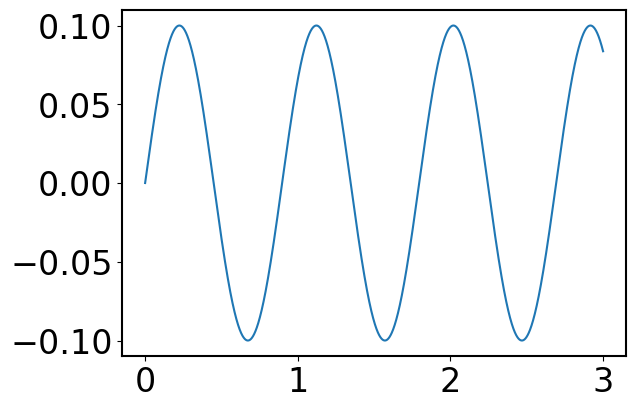

In [27]:
time = np.linspace(0,3,5000)

aaa  =  0.1*(np.sin(7*time))
plt.plot(time,aaa)

In [28]:
def Simulation(t_sim,Sys_Params,InitCond,k=100):

    time = np.linspace(0,t_sim,k)
    dt = time[1]-time[0]

    InitPos,InitSpeed = InitCond
    Dt,mass,charge,V0,d = Sys_Params

    List_part = Create_Particle_list(mass,charge)

    List_part = Init_Particle_list(List_part,InitPos,InitSpeed)
#     print(List_part[0].r)

    position = np.zeros([len(time),len(List_part)])
    velocity = np.zeros([len(time),len(List_part)])
    E_field = np.zeros([len(time),len(List_part)])

    count = 0

    for t in time:
        E = Electric_Field(List_part,V0,d,t,Dt)
        E_field[count] = E

        for j in range(len(List_part)):
            position[count][j] = List_part[j].r
            velocity[count][j] = List_part[j].v

            if List_part[j].r < 1 and List_part[j].r >=0:
                List_part[j].Heri_push(dt,E[j] + 0.5*(np.sin(0*t)))
            else:
#                 List_part[j].r = d
                List_part[j].v = 0

        count += 1

    return position,velocity,E_field

def Initial_position(N,params):
    e,E,m,dt  = params
    XV0 = np.zeros(N) # Initial conditions
    Dx_k = sheets_spacing(e,E,m,dt)

    for i in range(N):
        XV0[i] = (N-i)*Dx_k  # Sheet N is located at the cathode

    return XV0

# def distorsion(position,time,Dt,M):
#     t_init = Dt*(M-1)
#     i = 0
#     while  position[i,0] < 1:
#         i +=1

#     j = 0

#     while  position[j,-1] < 1:
#         j +=1

#     t_final = time[j] - time[i]
#     Distorsion = t_final / t_init

#     return Distorsion

def distorsion(position,frequency,Dt):
    sheet_i = int(1/(4*frequency*Dt))
    sheet_j = int(3/(4*frequency*Dt))

    for i in range(len(position)):
        if position[i,sheet_i] >= 1:
            break

    Distorsion = position[i,sheet_i] - position[i,sheet_j]

    return Distorsion

def Norm_J_crit_s(Xcl):

    return (3/4)/Xcl

def Norm_J_crit_e(Xcl):

    T1 = 2*(1-np.sqrt(1-(3/4)*Xcl**2))/Xcl**3

    return T1

def limit_charge(T0,Params_sys,ini_conds,iterations):

    tol = 1e-7

    Indicator = False
    position,velocity,E_field = Simulation(T0,Params_sys,ini_conds,iterations)

    if (position[-1,:] - position[0,:] < tol ).any():
        Indicator = True

    return Indicator

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e)))

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

#### Plots

In [29]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 5000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=1,label=f"$\\rho/\\rho^*$ = {int(100*(j+1)*0.25)}%")
#             plt.plot(shape[0],shape[1],lw=5,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.legend(fontsize=8)
            plt.xlim(0,1)
        ######################################################


            K = np.array([0])
            A = np.array([1])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
            plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=1)
#             plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

        ######################################################

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=1)
#             plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=.3)

#         plt.savefig(f'snapshots_sq{j}.jpg', dpi=400)
        plt.show()

In [30]:
# position_sq.shape

____

In [31]:
def triangular_wave_profile(rho_M, M, Dt, w, a):
    indices = np.arange(M)
    prof_ = rho_M * (1 - 2 * np.abs(((w * indices * Dt) % 1) - 0.5))
    return prof_

def square_wave_profile(rho_M, M, Dt, w, a):
    indices = np.arange(M)
    prof_ = rho_M * (1 + a*np.sign(np.sin(w * indices * Dt)))
    return prof_

def sin_profile(rho_M, M, Dt, w, a):
    indices = np.arange(M)
    prof_ = rho_M * (1 + a * np.sin(w * indices * Dt) )
    return prof_

def sawtooth_wave_profile(rho_M, M, Dt, w, a):
    indices = np.arange(M)
    prof_ = rho_M * (2 * a * ((w * indices * Dt) % 1) - 1)
    return prof_

Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)

def pulse_profile(N, Sigma, Dt, w=2*np.pi, a=1, Type='square'):
    Type = Type.lower()
    wave_functions = {
        'square': square_wave_profile,
        'sin': sin_profile,
        'triangle': triangular_wave_profile,
        'saw': sawtooth_wave_profile
    }
    wave_function = wave_functions.get(Type)
    if wave_function:
        return wave_function(Sigma, N, Dt, w, a)
    else:
        print('Profile not recognized')
        return None


#### Plots

____

# Injection Simulation

## Parameters

In [46]:
V0 = 0
d = 1.5e-3
M = 700
# rho_SCL = Sigma_1(V0,d)
# T0 = Time_transit(V0,d)
# Tcl = Time_CL(V0,d)

iterations = 5000
Dt = 1/M # Transit time in SCL Conditions
kp = 3
fp = 1

ini_pos = np.zeros(M)
indices = np.arange(M)
ini_speed = np.zeros(M) #np.sqrt(1 + 0.1 * np.sin(10*2*np.pi * indices * kp*Dt) )

ini_conds = [ini_pos,ini_speed]

time = np.linspace(0, 3,iterations)

## 1. Trajectories

In [47]:
charge = 1/M
mass = constants.m_e*abs(charge/constants.e)

[10. 20.]


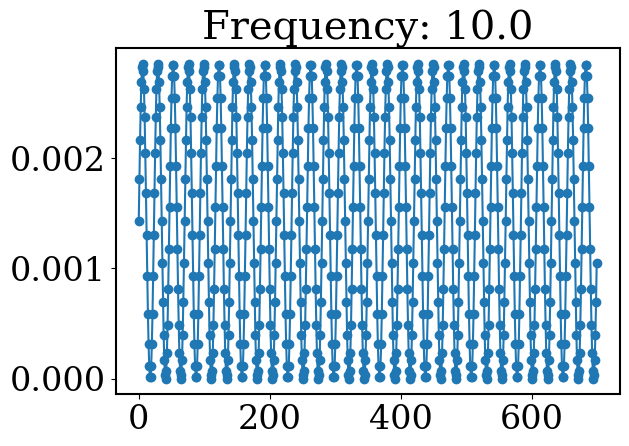

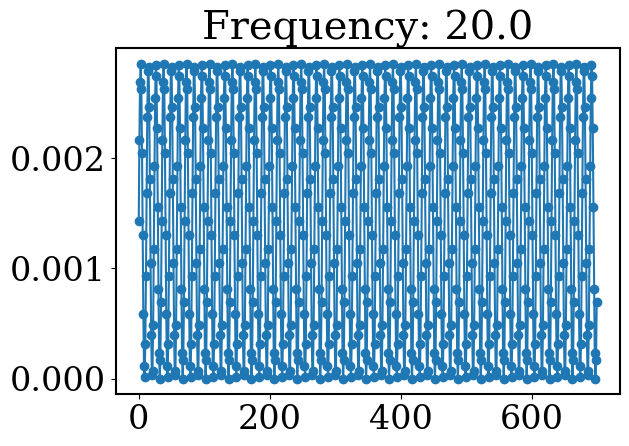

In [48]:
freq = np.linspace(10,20,2)
print(freq)
Sin_charge = []
Sin_mass = []

Params_sys = []

for i in range(len(freq)):

  fr = freq[i]
  Sin_charge.append(pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,Type='sin')*charge)
  Sin_mass.append(pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,Type='sin'))

  Params_sys.append([kp*Dt,fp*Sin_mass[i],fp*Sin_charge[i],V0,d])

  plt.title(f'Frequency: {fr}')
  plt.plot(Sin_charge[i],'o-',label=f'freq. = {fr}$f_t$')
  plt.show()

# plt.legend(fontsize=13)

# Params_sys_1 = [kp*Dt,fp*Sin_mass[0],fp*Sin_charge[0],V0,d]
# Params_sys_2 = [kp*Dt,fp*Sin_mass[1],fp*Sin_charge[1],V0,d]
# Params_sys_ = [kp*Dt,fp*Sin_mass[2],fp*Sin_charge[2],V0,d]
# Params_sys_2 = [kp*Dt,fp*Sin_mass[0],fp*Sin_charge[0],V0,d]
# Params_sys_4 = [kp*Dt,fp*Sin_mass[1],fp*Sin_charge[1],V0,d]
# Params_sys_6 = [kp*Dt,fp*Sin_mass[2],fp*Sin_charge[2],V0,d]

____

### 1.1 Sheet trajectories

In [49]:
Positions = []
Velocities = []
E_fields = []

for i in range(len(Params_sys)):
  _pos,_vel,_efi =  Simulation(3,Params_sys[i],ini_conds,iterations)
  Positions.append(_pos)
  Velocities.append(_vel)
  E_fields.append(_efi)

<ipython-input-50-f645a2388f14>:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(cmap,label='$\\rho_j$')


<Figure size 450x500 with 0 Axes>

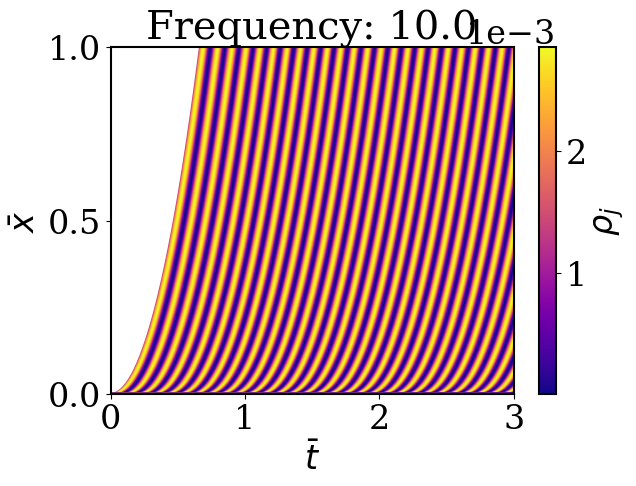

<Figure size 450x500 with 0 Axes>

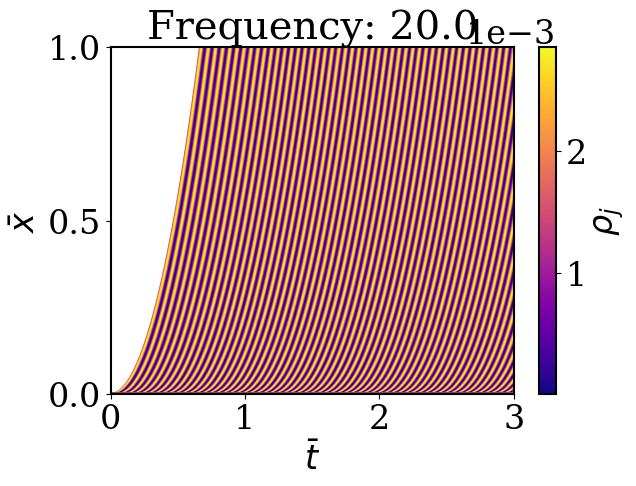

In [50]:
import matplotlib as mpl
for j in range(len(Params_sys)):

    plt.rc('font', family='serif')
    color_ = fp*Sin_charge[j]
    norm = mpl.colors.Normalize(vmin=color_.min(), vmax=color_.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
    cmap.set_array([])
    plt.figure(figsize=(4.5,5))
    fig, ax = plt.subplots(dpi=100)
    ax.set_title(f'Frequency: {freq[j]}')
    for i in range(M):
        ax.plot(time, Positions[j][:,i], c=cmap.to_rgba(color_[i]))
    cbar = fig.colorbar(cmap,label='$\\rho_j$')
    cbar.formatter.set_powerlimits((0, 0))
    plt.xlim(0,3)
    plt.xlabel('$\\bar{t}$',fontsize=24)
    plt.ylim(0,1)
    plt.ylabel('$\\bar{x}$',fontsize=24)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)

    plt.show()

### 1.2 Current density

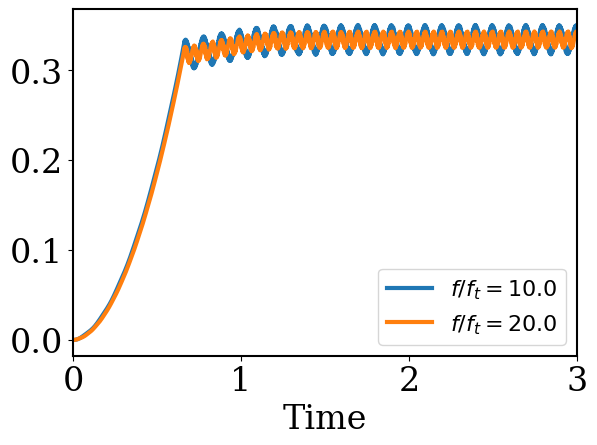

In [51]:
J = []
for i in range(len(Params_sys)):
  _j =  Current_density(Velocities[i],Sin_charge[i])

  J.append(_j)
  plt.plot(time,J[i],lw=3,label=f'$f/f_t = {freq[i]}$')

  plt.legend(fontsize=16.)
  plt.xlim(0,3)
  # plt.ylim(0.3,0.4)
  plt.xlabel('Time')

### 1.3 Field on Cathode

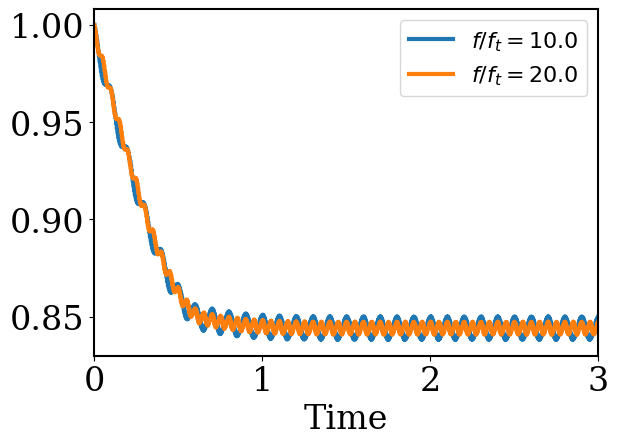

In [52]:
EK = []
for i in range(len(Params_sys)):
  _ek =  Field_cathode(Positions[i],Sin_charge[i],V0,d)

  EK.append(_ek)
  plt.plot(time,EK[i],lw=3,label=f'$f/f_t = {freq[i]}$')

  plt.legend(fontsize=16.)
  plt.xlim(0,3)
  plt.xlabel('Time')

### 1.4 Potential

In [ ]:
# position_sq[0,-1] - position_sq[-1,-1]

## 2. Evolution Snapshots

In [53]:
def plots_shape_phase_mult(position, velocity, E_field, rho, n=3):
    prof = ['Square', 'Trapezoidal', 'Gaussian']
    lag = 250
    len_rho = len(rho)

    for i in range(1, n+2):
        if i == n:
            lag = lag - 1

        fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))

        l = 2*(i-1)

        for j in range(len_rho):
            shape = np.array([position[j][lag * i], rho[j]])
            phase = np.array([position[j][lag * i], velocity[j][lag * i]])

            axs[0].plot(shape[0], shape[1],marker='o', lw=3, label=f"$f$ = {freq[j]}")
            axs[0].set_ylabel("$\\bar{\\rho}$")
            axs[0].set_xlim(0, 1)
            # axs[0].set_ylim(0, .1)

            if i == 1:
                axs[0].legend(fontsize=14)
            if j == 0:
                axs[0].annotate(f'({chr(97 + l)})', xy=(1, 0), xycoords='axes fraction', fontsize=16,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            axs[1].plot(phase[0], phase[1], lw=3)
            axs[1].set_ylabel("$\\bar{v}$")
            axs[1].set_xlim(0, 1)

            if  j == 0:
                axs[1].annotate(f'({chr(97 + l+1)})', xy=(1, 0), xycoords='axes fraction', fontsize=16,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            if i == n+1:
                axs[0].set_xlabel("$\\bar{x}$")
                axs[1].set_xlabel("$\\bar{x}$")

        axs[1].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        axs[0].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)

        fig.tight_layout(pad=.01)
        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

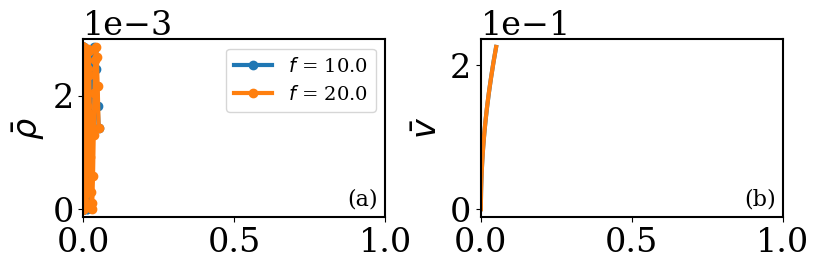

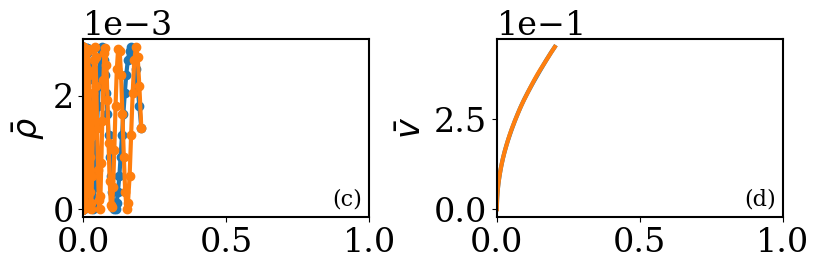

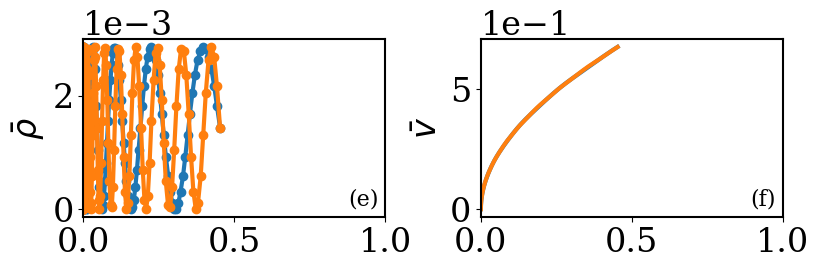

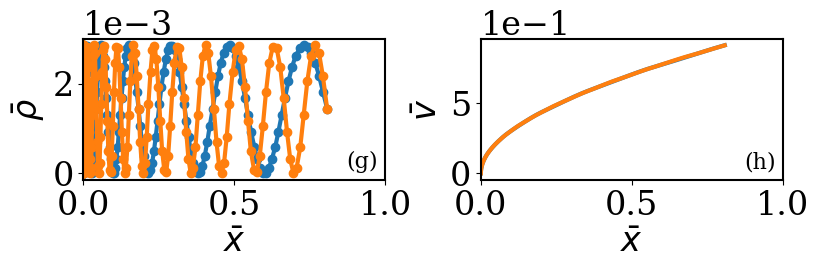

In [54]:
plots_shape_phase_mult(Positions,Velocities,E_fields,Sin_charge)

In [55]:
v = 0
shape = np.array([Positions[v][0],Sin_charge[v]])

fig, ax = plt.subplots()

plt.xlim(-0.0,1.0)
plt.title(f'$f/f_t$ = {freq[v]}')
line, = ax.plot(shape[0],shape[1],marker='o',lw=3)
plt.close(fig)

def animate(i):
    shape = np.array([Positions[v][15*i],Sin_charge[v]])
    line.set_data(shape[0],shape[1])  # update the data
    return line,

ani = (animation.FuncAnimation(fig, animate, np.arange(0, 250),interval=50, blit=True))
HTML(ani.to_html5_video())

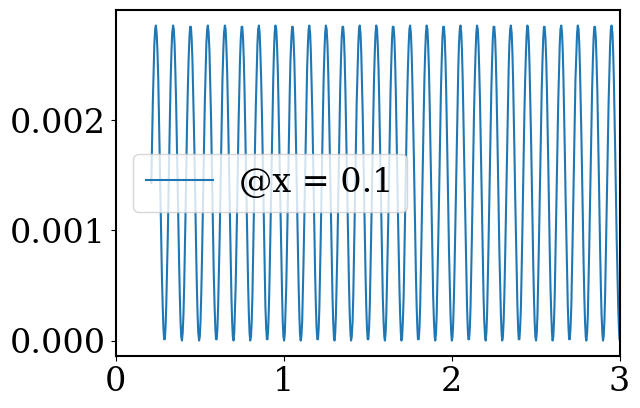

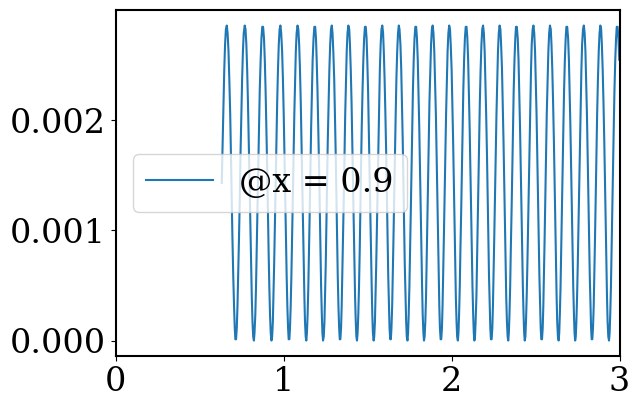

In [56]:
pos_ = [0.1,0.9]
for p in pos_:
  v = 0
  JA = []
  timeA = []
  for i in range(Positions[v].shape[1]):
    for j in range(Positions[v].shape[0]):
      if Positions[v][j][i] >= p :
        timeA.append(j)
        JA.append(Sin_charge[v][i])
        break

  plt.plot(time[timeA],JA,label = f'@x = {p}')
  plt.locator_params(axis='x', nbins=5)
  plt.xlim(0,3)
  plt.legend()
  plt.show()


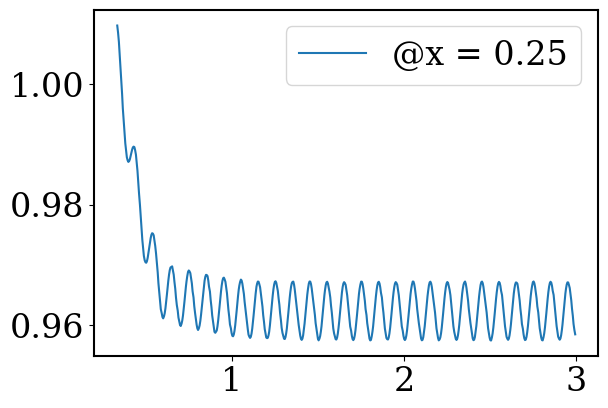

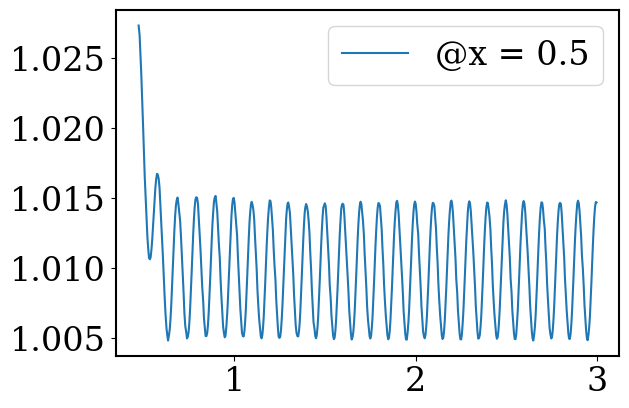

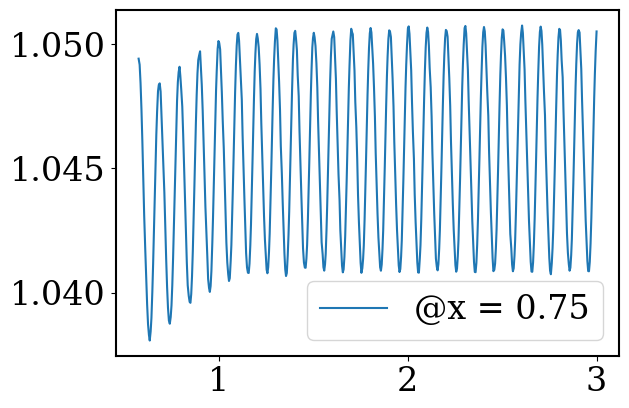

In [57]:
pos_ = [0.25,0.5,0.75]
for p in pos_:
  v = 0
  EB = []
  timeB = []
  for i in range(Positions[v].shape[1]):
    for j in range(Positions[v].shape[0]):
      if Positions[v][j][i] >= p :
        timeB.append(j)
        EB.append(E_fields[v][j][i])
        break

  plt.plot(time[timeB],EB,label = f'@x = {p}')
  plt.legend()
  plt.show()

### 1.5 Distorsion of the pulse

In [58]:
def th_distor(f,k):
  dist = (f**1)/k
  return dist

#### Distorsion with pulse frequency


In [ ]:
freq_range = np.linspace(10,30,5)
print(freq_range)
iterations = 5000
time = np.linspace(0, 3,iterations)

[10. 15. 20. 25. 30.]


In [ ]:
distorsion_list = []

for i in range(len(freq_range)):
  fr = freq_range[i]
  distorsion_list.append(distorsion(Positions[i],fr,kp*Dt))
distorsion_list = np.array(distorsion_list)

IndexError: list index out of range

In [ ]:
for i in range(len(freq_range)):

  plt.scatter(freq_range[i],distorsion_list[i],marker='^',s=100,label=f'$f$={np.round(freq_range[i],2)}')

plt.ylabel('Distortion')
plt.xlabel('$frequency$')
# plt.yscale('log')
plt.legend(fontsize=12)
plt.savefig('Dist_with_k.png', bbox_inches='tight', dpi=300)
  # plt.grid()

#### Distorsion with modulation depth

In [ ]:
freq_range

In [ ]:
a_range = [.1,.25,.5,.75,1]
print(a_range)
iterations = 5000
time = np.linspace(0, 3,iterations)

distorsion_list = []

for fr in freq_range:
    temp_list = []
    for i in range(len(a_range)):
        ai = a_range[i]
        sin_charge = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')*charge
        sin_mass = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')
        Params_sys = [kp*Dt,sin_mass,sin_charge,V0,d]
        position,velocity,E_field= Simulation(3,Params_sys,ini_conds,iterations)
        temp_list.append(distorsion(position,fr,kp*Dt))

    distorsion_list.append(np.array(temp_list))
distorsion_list = np.array(distorsion_list)

In [ ]:
print(distorsion_list)

In [ ]:
for i in range(len(freq_range)):
    plt.scatter(a_range,distorsion_list[i],marker='^',s=100,label=f'$f/f_t= {freq_range[i]}$')

plt.ylabel('Distortion')
plt.xlabel('$\\alpha$')

plt.legend(fontsize=12)
plt.savefig('Dist_with_f.png', bbox_inches='tight', dpi=300)

#### Distorsion with charge

In [ ]:
f_range = [.1,.25,.5,.75,1]
print(f_range)
iterations = 5000
time = np.linspace(0, 3,iterations)

distorsion_list = []

for fr in freq_range:
    temp_list = []
    for i in range(len(f_range)):
        f = f_range[i]
        sin_charge = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=1,Type='sin')*charge
        sin_mass = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=1,Type='sin')
        Params_sys = [kp*Dt,f*sin_mass,f*sin_charge,V0,d]
        position,velocity,E_field= Simulation(3,Params_sys,ini_conds,iterations)
        temp_list.append(distorsion(position,fr,kp*Dt))

    distorsion_list.append(np.array(temp_list))
distorsion_list = np.array(distorsion_list)

In [ ]:
print(distorsion_list)

In [ ]:
for i in range(len(freq_range)):
    plt.scatter(f_range,distorsion_list[i],marker='^',s=100,label=f'$f/f_t= {freq_range[i]}$')

plt.ylabel('Distortion')
plt.xlabel('$charge$')

plt.legend(fontsize=12)

#### Distorsion with charge and pulse frequency

In [ ]:
f_range = [.1,.25,.5,.75,1]  # Pulse charge range

Distorsion_matrix = np.zeros([len(f_range),len(freq_range)])

for i in range(len(f_range)):
    f = f_range[i]
    for j in range(len(freq_range)):
        fr = freq_range[j]
        sin_charge = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=1,Type='sin')*charge
        sin_mass = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=1,Type='sin')

        Params_sys = [kp*Dt,f*sin_mass,f*sin_charge,V0,d]
        position,_,_ = Simulation(3,Params_sys,ini_conds,iterations)

        Distorsion_matrix[i,j] = (distorsion(position,fr,kp*Dt))

In [ ]:
new_cm = cm.get_cmap('plasma_r',25)
Distorsion_matrix = np.flipud(Distorsion_matrix)

freq_range = np.flip(freq_range)

plt.figure(figsize=(4.5, 3.5))

heat_map = sns.heatmap(Distorsion_matrix,xticklabels=freq_range, yticklabels=f_range,cmap=new_cm,cbar=True)
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(freq_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(f_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$freq.$')
plt.ylabel('$charge$')

#### Distorsion with modulation depth and pulse frequency

In [ ]:
a_range = [.1,.25,.5,.75,1]  # Pulse charge range

Distorsion_matrix = np.zeros([len(f_range),len(freq_range)])

for i in range(len(a_range)):
    ai = a_range[i]
    for j in range(len(freq_range)):
        fr = freq_range[j]
        sin_charge = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')*charge
        sin_mass = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')

        Params_sys = [kp*Dt,sin_mass,sin_charge,V0,d]
        position,_,_ = Simulation(3,Params_sys,ini_conds,iterations)

        Distorsion_matrix[i,j] = (distorsion(position,fr,kp*Dt))

In [ ]:
new_cm = cm.get_cmap('plasma_r',25)
Distorsion_matrix = np.flipud(Distorsion_matrix)

# freq_range = np.flip(freq_range)

plt.figure(figsize=(9, 2.5))

heat_map = sns.heatmap(Distorsion_matrix,xticklabels=freq_range, yticklabels=a_range,cmap=new_cm,cbar=True)
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(freq_range) == 0 or index == len(a_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(a_range) == 0 or index == len(a_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$freq.$')
plt.ylabel('$\\alpha$')

#### Distorsion with modulation depth and pulse charge

In [ ]:
a_range = [.1,.25,.5,.75,1]  # Pulse charge range
f_range = [.1,.25,.5,.75,1]

Distorsion_matrix = np.zeros([len(f_range),len(freq_range)])

for i in range(len(a_range)):
    ai = a_range[i]
    for j in range(len(f_range)):
        f = f_range[j]
        fr = 10
        sin_charge = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')*charge
        sin_mass = pulse_profile(M,1,kp*Dt,w=fr*2*np.pi,a=ai,Type='sin')

        Params_sys = [kp*Dt,f*sin_mass,f*sin_charge,V0,d]
        position,_,_ = Simulation(3,Params_sys,ini_conds,iterations)

        Distorsion_matrix[i,j] = (distorsion(position,fr,kp*Dt))

In [ ]:
new_cm = cm.get_cmap('plasma_r',25)
Distorsion_matrix = np.flipud(Distorsion_matrix)

a_range = np.flip(a_range)

plt.figure(figsize=(9, 2.5))

heat_map = sns.heatmap(Distorsion_matrix,xticklabels=a_range, yticklabels=f_range,cmap=new_cm,cbar=True)
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(a_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(f_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$\\alpha$')
plt.ylabel('$Charge$')

# From Fourier Transform to Wavelet Transform

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 800
# sample spacing
T = 1.0 / N
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(5 * 2.0*np.pi*x) + 0.5*np.sin(10 * 2.0*np.pi*x) + 1.5*np.sin(20 * 2.0*np.pi*x)
plt.plot(x,y)
plt.show()
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
EB = np.array(EB)
EB.shape

In [ ]:
N = 50
yf = fft(EB[100:])
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
t_n = 1
N = 100000
T = t_n / N

xa = np.linspace(0, t_n, num=N)
xb = np.linspace(0, t_n/4, num=int(N/4))

frequencies = [20, 40, 60, 90]
y1a, y1b = np.sin(2*np.pi*frequencies[0]*xa), np.sin(2*np.pi*frequencies[0]*xb)
y2a, y2b = np.sin(2*np.pi*frequencies[1]*xa), np.sin(2*np.pi*frequencies[1]*xb)
y3a, y3b = np.sin(2*np.pi*frequencies[2]*xa), np.sin(2*np.pi*frequencies[2]*xb)
y4a, y4b = np.sin(2*np.pi*frequencies[3]*xa), np.sin(2*np.pi*frequencies[3]*xb)

signal1 = y1a + y2a + y3a + y4a
signal2 = np.concatenate([y1b, y2b, y3b, y4b])

yf1 = fft(signal1)
xf1 = fftfreq(N, T)[:150]

yf2 = fft(signal2)
xf2 = fftfreq(N, T)[:150]

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
axarr[0,0].plot(xa, signal1)
axarr[1,0].plot(xa, signal2)
axarr[0,1].plot(xf1,2.0/N * np.abs(yf1[0:150]))
axarr[1,1].plot(xf2,2.0/N * np.abs(yf2[0:150]))
(...)
plt.tight_layout()
plt.show()

In [ ]:
xf2